In [ ]:
import glob
import numpy as np
import scipy.io as sio
import pandas as pd
import matplotlib.pyplot as plt


In [ ]:
import os
import numpy as np
import tensorflow as tf
import keras
from keras.models import Model
from keras.layers import Add, Multiply, Dense, Input, Activation
import keras.backend.tensorflow_backend as KTF
import scipy.io as sio


def get_session(gpu_fraction=0.5):
    num_threads = os.environ.get('OMP_NUM_THREADS')
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=gpu_fraction)

    if num_threads:
        return tf.Session(config=tf.ConfigProto(gpu_options=gpu_options, intra_op_parallelism_threads=num_threads))
    else:
        return tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))


def makeModel(N, order=1):
    """
    To run the model, use the following:

    model = makeModel(n_dimensions, order)
    model.fit(X, Y, epochs=n_epochs, callbacks=[keras.callbacks.EarlyStopping()], validation_split=0.25)

    For the linear model, model.get_weights() returns the linear weights and the bias.
    For the quadratic model, model.get_weights() returns quadratic weights, dummy weights, linear weights, and the bias.
    """
    KTF.set_session(get_session())

    inLayer = Input((N,))
    linear = Dense(1, name='Linear')(inLayer)
    if order == 2:
        quad1 = Dense(N, kernel_initializer=keras.initializers.random_normal(stddev=0.001),
                      use_bias=False, name='Quad')(inLayer)
        quad2 = Multiply()([quad1, inLayer])
        quad3 = Dense(1, kernel_initializer='ones', use_bias=False, trainable=False)(quad2)
        x = Add()([quad3, linear])
        outLayer = Activation('sigmoid')(x)
    else:
        outLayer = Activation('sigmoid')(linear)
    model = Model(inLayer, outLayer)
    model.compile('rmsprop', 'binary_crossentropy')
    return model


def train_MNE(stimuli, spike_probs, order=2, val_split=0.25):
    """
    Creates and fits a MNE model

    Inputs:
    stimuli - numpy array of the stimuli.  Of shape (number of samples,dimension of stimulus)
    spike_probs - numpy array of the spiking probabilities.  Of shape (number of samples)

    order - The order of the MNE fit.  
        1 = first order linear filters only (standard logistic regression).  
        2 = also fit second order quadratic kernels.
    
    val_split - what percentage of data to set aside for early stopping on the validation set.  
        This will be lopped off the end of stimuli and spike_probs so I recommend having shuffled stimuli 
        and spike_probs initially. That way the validation split roughly matches the training distribution.

    Outputs:
    results - A python dictionary with resulting fitted parameters.
    """

    dim_x = stimuli.shape[1]
    model = makeModel(dim_x, order=order)

    model.fit(stimuli, spike_probs, verbose=0, epochs=40, 
              callbacks=[keras.callbacks.EarlyStopping(patience=2)], validation_split=val_split)
    if order == 1:
        w, bias = model.get_weights()
        results = {"linear": w, "bias": bias}
    else:
        J, dummy, w, bias = model.get_weights()
        J_sym = 0.5 * (J + np.transpose(J))
        results = {"quadratic": J_sym, "linear": w, "bias": bias}
    return results


In [ ]:
data_folder = 'F:/NHP/AD8/Ephys/20161205/hartley_gray'
trials_path = glob.glob(data_folder + '/trials.csv')[0]

trials = pd.read_csv(trials_path, index_col=0)
total_time = int(np.round(trials.stim_time[trials.index[-1]] - trials.stim_time[0]))
t_index = np.arange(0, total_time, 0.001)
stim = pd.DataFrame(np.zeros([total_time*1000, 2]), columns=['sfx', 'sfy'])

In [12]:
st = sio.loadmat("C:\\Users\\anupam\\Dropbox\\NHP cells\\spike_times_1.mat")['spike_times']
st_shift = st - trials.stim_time[0]
st_bins = np.histogram(st, bins=t_index)[0]

stim_time_shift = trials.stim_time - trials.stim_time[0]
stim_time_idx = np.searchsorted(stim_time_shift, t_index, side='right') - 1
stim_bins = trials.loc[stim_time_idx[:-1], ['sf_x', 'sf_y']]

In [ ]:
MNE_test = train_MNE(stim_bins.as_matrix(), st_bins)

In [17]:
MNE_test

{'bias': array([-16.11840248], dtype=float32), 'linear': array([[-7.86706543],
        [ 0.15429549]], dtype=float32), 'quadratic': array([[-7.00103807,  0.1253639 ],
        [ 0.1253639 , -7.06098032]], dtype=float32)}

In [63]:
unique_stim = stim_bins.drop_duplicates().as_matrix()
term_lin = term2 = np.dot(MNE_test['linear'].T, unique_stim.T)
bias = MNE_test['bias']
spike_prob = 1 / (1 + np.exp((term_lin + bias)))

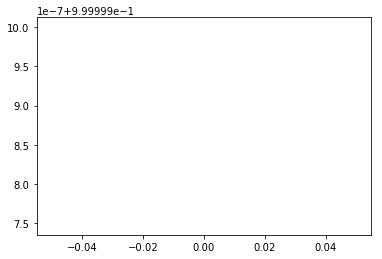

In [64]:
import matplotlib.pyplot as plt
plt.plot(spike_prob)
plt.show()

In [65]:
spike_prob

array([[ 1.        ,  1.        ,  1.        , ...,  1.        ,
         0.99999995,  0.99999994]])